### 專案名稱: 第四屆機器學習百日馬拉松
### 功能描述: 第51~53天作業(期中考)_V1
### 版權所有: Dunk  
### 程式撰寫: Dunk  
### 撰寫日期：2020/04/27
### 改版日期:  
### 改版備註: 
### 2020/04/29 增加梯度提升機及隨機森林
### 2020/04/30 增加資料清洗與評估結果顯示
### 2020/05/04 增加資料清洗
### 2020/05/06 增加說明
### 2020/05/08 調整離峰值處理
### 參考網址
https://github.com/valmikkpatel/enron-fraud-detection

請至以下Kaggle競賽平台期中考連結參加考試，請按join competition加入測驗 

並將任一次提交完成畫面截圖，上傳到github並回到官網完成提交。(提交畫面截圖範例)

https://www.kaggle.com/t/4e455552ac9b4a088ccae16e27d22be8

### ANS:

## 目錄
* <a href="#sec1">1. 簡介</a>
  * <a href="#sec1.1"> 1.1. 匯入所需套件 </a>

* <a href="#sec2">2. 資料清洗</a>
  * <a href="#sec2.1"> 2.1. 匯入資料集 </a>
  * <a href="#sec2.2"> 2.2. 分析資料型態與分布 </a>
  * <a href="#sec2.3"> 2.3. 資料填補分析 </a>
  * <a href="#sec2.4"> 2.4. 缺失值填補 </a>
  * <a href="#sec2.5"> 2.5. 離峰值處理 </a>
  * <a href="#sec2.6"> 2.6. 異常值處理 </a>
  * <a href="#sec2.7"> 2.7. 資料檢查 </a>

* <a href="#sec3">3. 特徵工程</a>
  * <a href="#sec3.1"> 3.1. 特徵分析 </a>
  * <a href="#sec3.2"> 3.2. 特徵縮放 </a>
  * <a href="#sec3.3"> 3.3. 特徵選擇 </a>
  
* <a href="#sec4">4. 套用模型</a>
  * <a href="#sec4.1"> 4.1. 超參數調整 </a>
  * <a href="#sec4.2"> 4.2. 測試及驗證 </a>  

<a id='sec1'></a>
### 1. 簡介
該項目是Udacity Data Analyst Nanodegree的一部分，涉及機器學習入門模塊。其主要範圍是根據因安然（Enron）醜聞而公開的財務和電子郵件數據來構建感興趣的人（POI）標識符，如下所述。
2000年，安然（Enron）是美國最大的公司之一。到2002年，由於廣泛的公司欺詐行為，該公司破產了。在最終的聯邦調查中，大量的通常是機密信息被輸入到公共記錄中，包括成千上萬的電子郵件和高級管理人員的詳細財務數據。

<a id='sec1.1'></a>
#### 1.1. 匯入套件及資料
本節為將在此python筆記本中使用的所有套件匯入

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import os
import pandas as pd
import numpy as np
import copy
from time import time 
import pprint
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
from sklearn.feature_selection import SelectKBest, f_classif

### Importing Models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

<a id='sec2'></a>
### 2. 資料清洗

<a id='sec2.1'></a>
#### 2.1. 匯入資料集

In [2]:
data_path = 'data/'
df_train = pd.read_csv(data_path + 'train_data.csv')
df_test = pd.read_csv(data_path + 'test_features.csv')
index_name = 'name'
df_train = df_train.set_index(df_train[index_name])
df_test = df_test.set_index(df_test[index_name])
print(df_train.shape)
print(df_test.shape)

(113, 22)
(33, 21)


<a id='sec2.2'></a>
#### 2.2. 分析資料型態與分布

In [3]:
# 重組資料成為訓練 / 預測用格式
target_col = 'poi'
key_col = 'name'
df_train[target_col] = df_train[target_col].map(lambda i: 1 if i == True else 0)
ids = df_test[key_col]
df_train = df_train.drop([key_col] , axis=1)
df_test = df_test.drop([key_col] , axis=1)
print(df_train.shape)
print(df_test.shape)

(113, 21)
(33, 20)


In [4]:
# 秀出資料欄位的類型與數量
dtype_df = df_train.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df = dtype_df.groupby("Column Type").aggregate('count').reset_index()
dtype_df

,Column Type,Count
0,int64,1
1,float64,19
2,object,1


In [5]:
#確定只有 int64, float64, object 三種類型後, 分別將欄位名稱存於二個 list(數值及文字) 中
num_features = []
object_features = []
for dtype, feature in zip(df_train.dtypes, df_train.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)    
    else:
        object_features.append(feature)
# 將poi值移除
num_features.remove('poi')        
print(f'{len(num_features)} num Features : {num_features}\n')
print(f'{len(object_features)} Object Features : {object_features}')

19 num Features : ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value']

1 Object Features : ['email_address']


In [6]:
def visualize3Feats(dataset, features):
    '''Shows the distribution and the boxplot for the given features of a pandas.Dataframe:
        dataset = pandas dataframe.
        features = list of features of interest'''
    ## Building the Figure:
    fig, axes = plt.subplots(2,3,figsize=(15,6), sharex=False)
    for col, feat in enumerate(features):
        dataset[feat].plot(kind='kde', ax=axes[0,col])
        sns.boxplot(x=dataset[feat], ax=axes[1,col])
        axes[0,col].set_xlim(dataset[feat].min(), dataset[feat].max()*1.1);
        axes[1,col].set_xlim(dataset[feat].min(), dataset[feat].max()*1.1);
    return

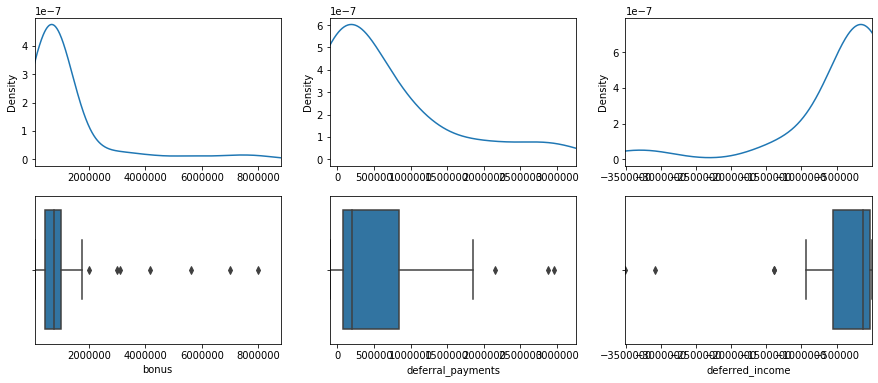

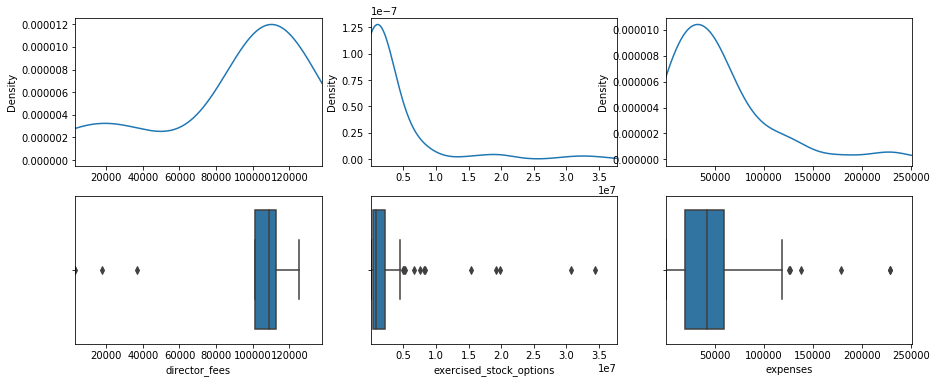

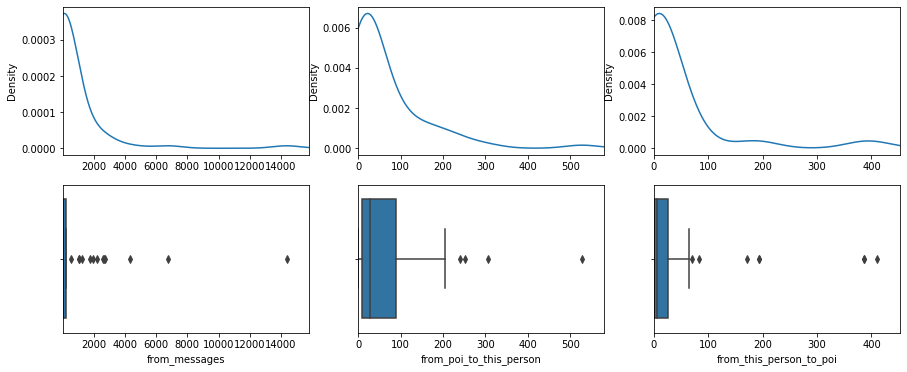

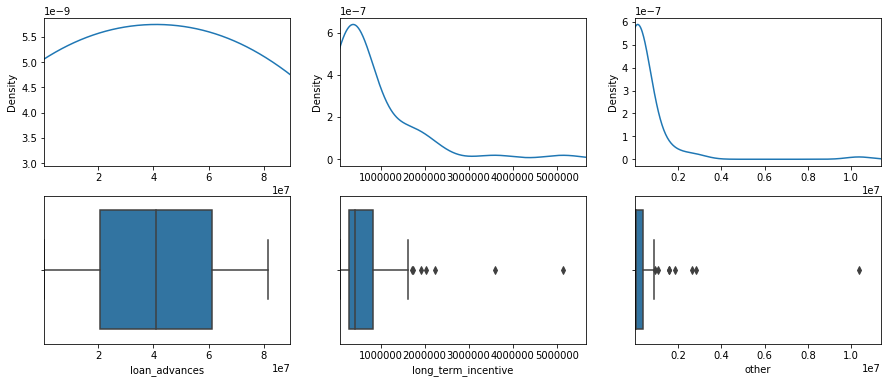

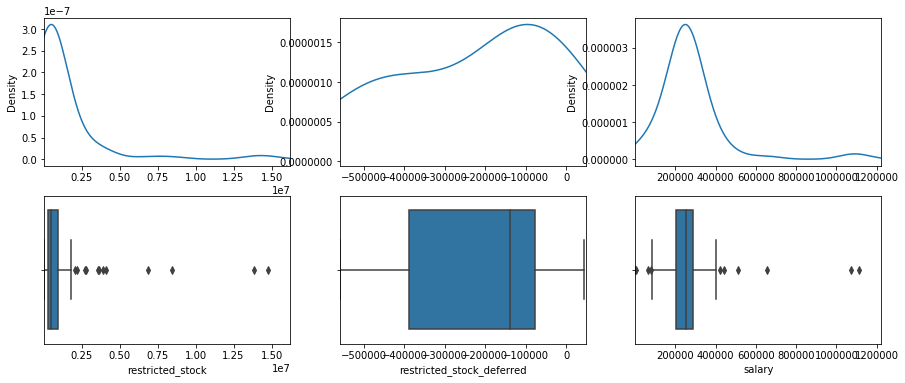

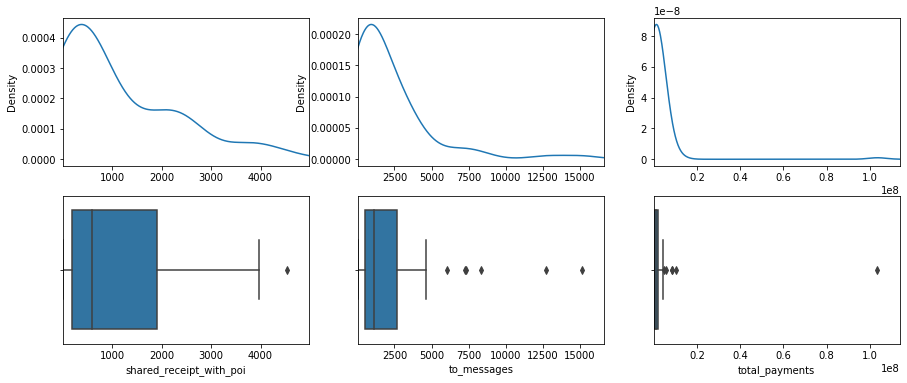

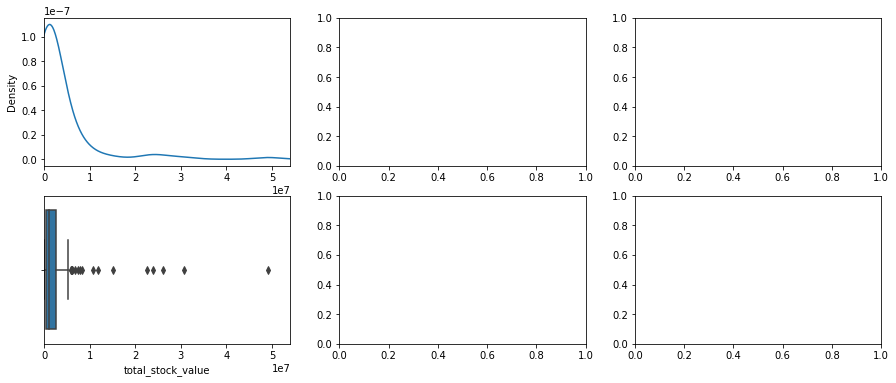

In [7]:
### 繪製KDE圖型及箱型圖:
numPlots = int(np.ceil(len(num_features)/3.))
for i in range(numPlots):
    shift = i*3
    visualize3Feats(df_train,num_features[0+shift:3+shift])

In [8]:
# 欄位值計算
print(df_train.select_dtypes(include=["object"]).apply(pd.Series.nunique, axis = 0).sort_values())
print('----------------------')
print(df_train.select_dtypes(include=["int64"]).apply(pd.Series.nunique, axis = 0).sort_values())
print('----------------------')
print(df_train.select_dtypes(include=["float64"]).apply(pd.Series.nunique, axis = 0).sort_values())
# 欄位值計算

email_address    83
dtype: int64
----------------------
poi    2
dtype: int64
----------------------
loan_advances                 2
restricted_stock_deferred    10
director_fees                13
deferral_payments            28
deferred_income              30
from_this_person_to_poi      32
bonus                        33
long_term_incentive          40
from_poi_to_this_person      45
from_messages                51
shared_receipt_with_poi      64
to_messages                  65
other                        69
expenses                     72
restricted_stock             73
salary                       73
exercised_stock_options      80
total_payments               96
total_stock_value            96
dtype: int64


In [9]:
# 欄位值計算
print(df_test.select_dtypes(include=["object"]).apply(pd.Series.nunique, axis = 0).sort_values())
print('----------------------')
print(df_test.select_dtypes(include=["int64"]).apply(pd.Series.nunique, axis = 0).sort_values())
print('----------------------')
print(df_test.select_dtypes(include=["float64"]).apply(pd.Series.nunique, axis = 0).sort_values())
# 欄位值計算

email_address    28
dtype: int64
----------------------
Series([], dtype: float64)
----------------------
loan_advances                 2
director_fees                 4
restricted_stock_deferred     8
deferral_payments            11
deferred_income              15
long_term_incentive          16
from_this_person_to_poi      16
bonus                        18
from_poi_to_this_person      18
from_messages                19
exercised_stock_options      21
salary                       21
shared_receipt_with_poi      21
to_messages                  21
expenses                     22
other                        24
restricted_stock             27
total_stock_value            28
total_payments               29
dtype: int64


<a id='sec2.3'></a>
#### 2.3. 資料填補分析

In [10]:
#檢查統計值
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
bonus,61.0,1.147436e+06,1.505189e+06,70000.0,450000.00,750000.0,1000000.00,8000000.0
deferral_payments,28.0,6.344374e+05,8.603646e+05,-102500.0,76567.50,195190.0,834205.25,2964506.0
deferred_income,34.0,-4.625664e+05,8.095392e+05,-3504386.0,-552703.25,-117534.0,-27083.25,-1042.0
director_fees,13.0,8.939785e+04,4.114339e+04,3285.0,101250.00,108579.0,112492.00,125034.0
exercised_stock_options,81.0,2.985081e+06,6.004174e+06,3285.0,400478.00,850010.0,2165172.00,34348384.0
expenses,73.0,5.104055e+04,4.759668e+04,148.0,18834.00,41953.0,59175.00,228763.0
from_messages,65.0,7.113231e+02,2.074498e+03,12.0,19.00,45.0,215.00,14368.0
from_poi_to_this_person,65.0,6.480000e+01,9.186321e+01,0.0,10.00,28.0,88.00,528.0
from_this_person_to_poi,65.0,4.009231e+01,8.890141e+01,0.0,0.00,7.0,27.00,411.0
loan_advances,2.0,4.096250e+07,5.736404e+07,400000.0,20681250.00,40962500.0,61243750.00,81525000.0


In [11]:
df_test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
bonus,21.0,5.937791e+06,2.097902e+07,100000.0,425000.00,1000000.0,2000000.00,97343619.0
deferral_payments,11.0,4.209095e+06,9.442610e+06,51365.0,232265.00,564348.0,2637936.50,32083396.0
deferred_income,15.0,-2.677068e+06,7.096873e+06,-27992891.0,-1809217.00,-235000.0,-129288.00,-833.0
director_fees,4.0,4.183778e+05,6.547074e+05,38346.0,83674.50,118324.0,453027.25,1398517.0
exercised_stock_options,21.0,1.756609e+07,6.746116e+07,765920.0,1030329.00,2027865.0,4160672.00,311764000.0
expenses,22.0,3.001494e+05,1.102936e+06,2151.0,34283.75,61817.0,96182.00,5235198.0
from_messages,21.0,2.914286e+02,7.026554e+02,12.0,25.00,29.0,75.00,3069.0
from_poi_to_this_person,21.0,6.519048e+01,7.175278e+01,0.0,28.00,40.0,64.00,242.0
from_this_person_to_poi,21.0,4.476190e+01,1.313537e+02,0.0,1.00,12.0,21.00,609.0
loan_advances,2.0,4.296250e+07,5.792972e+07,2000000.0,22481250.00,42962500.0,63443750.00,83925000.0


In [12]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data)

In [13]:
na_check(df_train)
na_check(df_test)

,Missing Ratio
loan_advances,98.230088
restricted_stock_deferred,91.150442
director_fees,88.495575
deferral_payments,75.221239
deferred_income,69.911504
long_term_incentive,56.637168
bonus,46.017699
from_messages,42.477876
from_poi_to_this_person,42.477876
from_this_person_to_poi,42.477876


,Missing Ratio
loan_advances,93.939394
director_fees,87.878788
restricted_stock_deferred,75.757576
deferral_payments,66.666667
deferred_income,54.545455
long_term_incentive,48.484848
from_this_person_to_poi,36.363636
from_poi_to_this_person,36.363636
exercised_stock_options,36.363636
from_messages,36.363636


<a id='sec2.4'></a>
#### 2.4. 缺失值填補

In [14]:
# 付款資料
payment_data = ['salary','bonus','long_term_incentive','deferred_income','deferral_payments','loan_advances','other'\
               ,'expenses','director_fees','total_payments']
# 股票資產資料
stock_data = ['exercised_stock_options','restricted_stock','restricted_stock_deferred',\
             'total_stock_value']
# 郵件次數資料
email_data=['from_this_person_to_poi','from_poi_to_this_person','to_messages',\
            'shared_receipt_with_poi','to_messages','from_messages']

# 缺失值補0(email次數,付款資料,股票資產資料)
df_train[num_features] = df_train[num_features].fillna(0)
df_test[num_features] = df_test[num_features].fillna(0)

In [15]:
#顯示訓練集其中資料遺失比例(只剩email_address)
na_check(df_train)
na_check(df_test)

,Missing Ratio
email_address,26.548673


,Missing Ratio
email_address,15.151515


<a id='sec2.5'></a>
#### 2.5. 離峰值處理

df_train outlier
0    112
1      1
Name: outlier, dtype: int64
df_test outlier
0    32
1     1
Name: outlier, dtype: int64


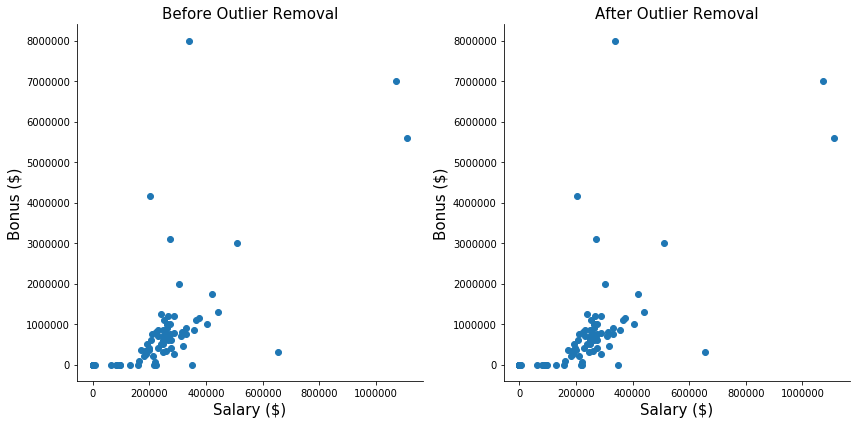

In [16]:
# TOTAL 及 THE TRAVEL AGENCY IN THE PARK 是合計欄(非個人資料)，要刪除
### Visualizing Salary v/s Balance Graphs for outlier identification
figure, (axes1, axes2) = plt.subplots(ncols=2, figsize=(12, 6))

axes1.scatter(df_train.salary, df_train.bonus)
axes1.set_xlabel("Salary ($)", fontsize=15)
axes1.set_ylabel("Bonus ($)", fontsize=15)
axes1.set_title("Before Outlier Removal", fontsize=15)
axes1.spines['right'].set_visible(False)
axes1.spines['top'].set_visible(False)

# print('index[total]:{0}'.format(str(len(df_train[df_train.index == 'TOTAL']))))
# print('index[THE TRAVEL AGENCY IN THE PARK]:{0}'.format(str(len(df_train[df_train.index\
# == 'THE TRAVEL AGENCY IN THE PARK']))))
# # Dropping the outliers
# outlier_set = ['TOTAL','THE TRAVEL AGENCY IN THE PARK']
# for outle in outlier_set:
#     if outle in df_train.index:
#         df_train.drop([outle], axis = 0, inplace=True)        
# print('index[total]:{0}'.format(str(len(df_train[df_train.index == 'TOTAL']))))
# print('index[THE TRAVEL AGENCY IN THE PARK]:{0}'.format(str(len(df_train[df_train.index\
# == 'THE TRAVEL AGENCY IN THE PARK']))))
# print(df_train.shape)

# 離峰值增加欄位住記
df_train['outlier']= 0
df_test['outlier']= 0
outlier_set = ['TOTAL','THE TRAVEL AGENCY IN THE PARK']
for indexs in outlier_set:
    if indexs in df_train.index:
        df_train.loc[indexs,'outlier'] = 1
    if indexs in df_test.index:
        df_test.loc[indexs,'outlier'] = 1

print('df_train outlier')
print(df_train['outlier'].value_counts())
print('df_test outlier')
print(df_test['outlier'].value_counts())



axes2.scatter(df_train.salary, df_train.bonus)
axes2.set_xlabel("Salary ($)", fontsize=15)
axes2.set_ylabel("Bonus ($)", fontsize=15)
axes2.set_title("After Outlier Removal", fontsize=15)
axes2.spines['right'].set_visible(False)
axes2.spines['top'].set_visible(False)

figure.tight_layout()
plt.show()

<a id='sec2.6'></a>
#### 2.6. 異常值處理

In [17]:
#驗證資料內容前先複製一份
dt_eval = pd.concat([df_train,df_test])

In [18]:
# 計算付款資料合理性
errors = (dt_eval[dt_eval[payment_data[:-1]].sum(axis='columns') !=dt_eval['total_payments']])
print(errors.shape)
errors

(2, 22)


,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,outlier
name,,,,,,,,,,,,,,,,,,,,,
BELFER ROBERT,0.0,-102500.0,0.0,3285.0,NaN,3285.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,44093.0,0.0,0.0,0.0,102500.0,-44093.0,0
BHATNAGAR SANJAY,0.0,0.0,0.0,137864.0,sanjay.bhatnagar@enron.com,2604490.0,0.0,29.0,0.0,1.0,...,137864.0,NaN,-2604490.0,15456290.0,0.0,463.0,523.0,15456290.0,0.0,0


In [19]:
# 計算股票資產資料合理性
errors = (dt_eval[dt_eval[stock_data[:-1]].sum(axis='columns') !=dt_eval['total_stock_value']])
print(errors.shape)
errors

(2, 22)


,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,outlier
name,,,,,,,,,,,,,,,,,,,,,
BELFER ROBERT,0.0,-102500.0,0.0,3285.0,NaN,3285.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,44093.0,0.0,0.0,0.0,102500.0,-44093.0,0
BHATNAGAR SANJAY,0.0,0.0,0.0,137864.0,sanjay.bhatnagar@enron.com,2604490.0,0.0,29.0,0.0,1.0,...,137864.0,NaN,-2604490.0,15456290.0,0.0,463.0,523.0,15456290.0,0.0,0


In [20]:
# 查看有問題的兩筆資料，發現資料位移
# 處理訓練集
# Check for any more errors with the payment data
print(len(df_train[df_train[payment_data[:-1]].sum(axis='columns') !=df_train['total_payments']]))
# Check for any errors with the stock data
print(len(df_train[df_train[stock_data[:-1]].sum(axis='columns') !=df_train['total_stock_value']]))

payment_len = df_train[payment_data[:-1]].shape[1]
stock_len = df_train[stock_data[:-1]].shape[1]

# 'BELFER ROBERT' 資料發現左移,向右SHIFT
key_name = 'BELFER ROBERT'
key_name in df_train.index
if key_name in df_train.index:
    print('find {0} !'.format(str(key_name)))
    for i in range(payment_len):
        df_train.loc[key_name,payment_data[i]] = df_train.loc[key_name,payment_data[i+1]]
    df_train.loc[key_name,payment_data[payment_len]] = df_train.loc[key_name,stock_data[0]]

    for i in range(stock_len):
        df_train.loc[key_name,stock_data[i]] = float(df_train.loc[key_name,stock_data[i+1]])
    df_train.loc[key_name,stock_data[stock_len]] = 0


# 'BHATNAGAR SANJAY' 資料發現右移,向左SHIFT
key_name = 'BHATNAGAR SANJAY'
if key_name in df_train.index:
    print('find {0} !'.format(str(key_name)))
    for i in np.arange(1,stock_len+1)[::-1]:
        df_train.loc[key_name,stock_data[i]] = float(df_train.loc[key_name,stock_data[i-1]])
    df_train.loc[key_name,stock_data[0]] = df_train.loc[key_name,payment_data[payment_len]]

    for i in np.arange(1,payment_len+1)[::-1]:
        df_train.loc[key_name,payment_data[i]] = df_train.loc[key_name,payment_data[i-1]]
    df_train.loc[key_name,payment_data[0]] = 0

# Check for any more errors with the payment data
print(len(df_train[df_train[payment_data[:-1]].sum(axis='columns') !=df_train['total_payments']]))
# Check for any errors with the stock data
print(len(df_train[df_train[stock_data[:-1]].sum(axis='columns') !=df_train['total_stock_value']]))

1
1
find BELFER ROBERT !
0
0


In [21]:
# 查看有問題的兩筆資料，發現資料位移
# 處理測試集
# Check for any more errors with the payment data
print(len(df_test[df_test[payment_data[:-1]].sum(axis='columns') !=df_test['total_payments']]))
# Check for any errors with the stock data
print(len(df_test[df_test[stock_data[:-1]].sum(axis='columns') !=df_test['total_stock_value']]))

payment_len = df_test[payment_data[:-1]].shape[1]
stock_len = df_test[stock_data[:-1]].shape[1]

# 'BELFER ROBERT' 資料發現左移,向右SHIFT
key_name = 'BELFER ROBERT'
key_name in df_test.index
if key_name in df_test.index:
    print('find {0} !'.format(str(key_name)))
    for i in range(payment_len):
        df_test.loc[key_name,payment_data[i]] = df_test.loc[key_name,payment_data[i+1]]
    df_test.loc[key_name,payment_data[payment_len]] = df_test.loc[key_name,stock_data[0]]

    for i in range(stock_len):
        df_test.loc[key_name,stock_data[i]] = float(df_test.loc[key_name,stock_data[i+1]])
    df_test.loc[key_name,stock_data[stock_len]] = 0


# 'BHATNAGAR SANJAY' 資料發現右移,向左SHIFT
key_name = 'BHATNAGAR SANJAY'
if key_name in df_test.index:
    print('find {0} !'.format(str(key_name)))
    for i in np.arange(1,stock_len+1)[::-1]:
        df_test.loc[key_name,stock_data[i]] = float(df_test.loc[key_name,stock_data[i-1]])
    df_test.loc[key_name,stock_data[0]] = df_test.loc[key_name,payment_data[payment_len]]

    for i in np.arange(1,payment_len+1)[::-1]:
        df_test.loc[key_name,payment_data[i]] = df_test.loc[key_name,payment_data[i-1]]
    df_test.loc[key_name,payment_data[0]] = 0

# Check for any more errors with the payment data
print(len(df_test[df_test[payment_data[:-1]].sum(axis='columns') !=df_test['total_payments']]))
# Check for any errors with the stock data
print(len(df_test[df_test[stock_data[:-1]].sum(axis='columns') !=df_test['total_stock_value']]))

1
1
find BHATNAGAR SANJAY !
0
0


In [22]:
# 檢查次數項目是否為正整數(大於等於0)
for col_name in email_data:    
    if all(dt_eval[col_name].dropna().unique()>=0):
        print('column [{0}] pass!'.format(col_name))        
    else:
        print('column [{0}] fail!'.format(col_name))
        print(dt_eval[col_name].dropna().unique())

column [from_this_person_to_poi] pass!
column [from_poi_to_this_person] pass!
column [to_messages] pass!
column [shared_receipt_with_poi] pass!
column [to_messages] pass!
column [from_messages] pass!


<a id='sec2.7'></a>
#### 2.7. 資料檢查

In [23]:
#顯示訓練集與測試集其中資料遺失比例(只剩email_address)
na_check(df_train)
na_check(df_test)

,Missing Ratio
email_address,26.548673


,Missing Ratio
email_address,15.151515


<a id='sec3'></a>
### 3.特徵工程

<a id='sec3.1'></a>
#### 3.1. 特徵分析

Feature engineering involves using human intuition to hypothesize what feature might contain pattern that can be exploited using machine learning, coding up the new feature, visualizing and repeating the same process again. Our hypothesis here - "POI's sent email to each other at a rate higher than for Non-POI's." I coded up two new features fraction of emails this person gets from poi (fraction_from_poi) and fraction of emails this person send to poi (fraction_to_poi). number of emails from this person to POI/total number of message from this person

$$ fraction\_from\_poi = \frac{number\ of\ emails\ from\ POI\ to\ this\ person}{total\ number\ of\ messages\ to\ this\  person} = \frac{from\_poi\_to\_this\_person}{to\_messages} $$

$$ fraction\_to\_poi = \frac{number\ of\ emails\ from\ this\ person\ to\ POI}{total\ number\ of\ messages\ from\ this\ person} = \frac{from\_this\_person\_to\_poi}{from\_messages} $$

When I visualize these new features, we can see that these new features provide discriminating power between POI and Non-POI. There is a good amount of feature space in the lower part of plot (on right) below 0.2 where there are no POIs.

In [24]:
### Creating new features fraction_from_poi and fraction_to_poi
df_train["fraction_from_poi"] = df_train["from_poi_to_this_person"].\
                                  divide(df_train["to_messages"], fill_value=0.0) 

df_train["fraction_to_poi"] = df_train["from_this_person_to_poi"].\
                                divide(df_train["from_messages"], fill_value=0.0)
df_train['shared_receipt_poi_ratio'] = df_train['shared_receipt_with_poi'].\
                                 divide(df_train['to_messages'], fill_value=0.0)

df_train['bonus_to_salary'] = df_train['bonus'].divide(df_train['salary'], fill_value=0.0)
df_train['bonus_to_total'] = df_train['bonus'].divide(df_train['total_payments'], fill_value=0.0)

df_train["fraction_from_poi"] = df_train["fraction_from_poi"].fillna(0.0)
df_train["fraction_to_poi"] = df_train["fraction_to_poi"].fillna(0.0)
df_train["shared_receipt_poi_ratio"] = df_train["shared_receipt_poi_ratio"].fillna(0.0)
df_train["bonus_to_salary"] = df_train["bonus_to_salary"].fillna(0.0)
df_train["bonus_to_total"] = df_train["bonus_to_total"].fillna(0.0)

In [25]:
### Creating new features fraction_from_poi and fraction_to_poi
df_test["fraction_from_poi"] = df_test["from_poi_to_this_person"].\
                                  divide(df_test["to_messages"], fill_value=0.0) 

df_test["fraction_to_poi"] = df_test["from_this_person_to_poi"].\
                                divide(df_test["from_messages"], fill_value=0.0)
df_test['shared_receipt_poi_ratio'] = df_test['shared_receipt_with_poi'].\
                                 divide(df_test['to_messages'], fill_value=0.0)

df_test['bonus_to_salary'] = df_test['bonus'].divide(df_test['salary'], fill_value=0.0)
df_test['bonus_to_total'] = df_test['bonus'].divide(df_test['total_payments'], fill_value=0.0)

df_test["fraction_from_poi"] = df_test["fraction_from_poi"].fillna(0.0)
df_test["fraction_to_poi"] = df_test["fraction_to_poi"].fillna(0.0)
df_test["shared_receipt_poi_ratio"] = df_test["shared_receipt_poi_ratio"].fillna(0.0)
df_test["bonus_to_salary"] = df_test["bonus_to_salary"].fillna(0.0)
df_test["bonus_to_total"] = df_test["bonus_to_total"].fillna(0.0)

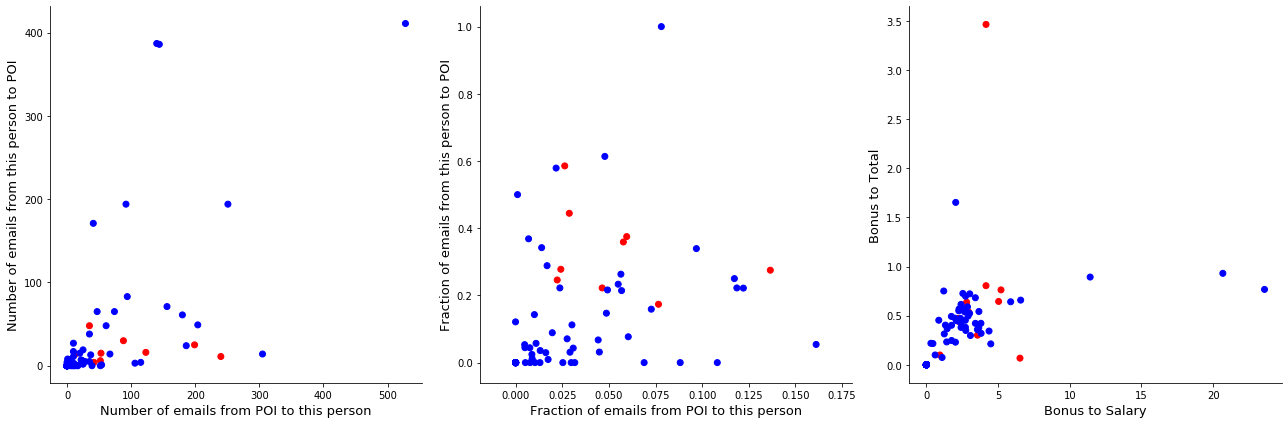

In [26]:
### Visualizing the effect of new features
figure, (axes1, axes2, axes3) = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
# Color scheme for plots
colors = np.where(df_train["poi"] == 1, 'r', 'o')
colors[df_train["poi"] == 0] = 'b'

axes1.scatter(df_train["from_poi_to_this_person"], df_train["from_this_person_to_poi"], color=colors)
axes1.set_xlabel("Number of emails from POI to this person", fontsize=13)
axes1.set_ylabel("Number of emails from this person to POI", fontsize=13)
axes1.spines['right'].set_visible(False)
axes1.spines['top'].set_visible(False)

axes2.scatter(df_train["fraction_from_poi"], df_train["fraction_to_poi"], color=colors)
axes2.set_xlabel("Fraction of emails from POI to this person", fontsize=13)
axes2.set_ylabel("Fraction of emails from this person to POI", fontsize=13)
axes2.spines['right'].set_visible(False)
axes2.spines['top'].set_visible(False)

axes3.scatter(df_train["bonus_to_salary"], df_train["bonus_to_total"], color=colors)
axes3.set_xlabel("Bonus to Salary", fontsize=13)
axes3.set_ylabel("Bonus to Total", fontsize=13)
axes3.spines['right'].set_visible(False)
axes3.spines['top'].set_visible(False)

figure.tight_layout()
plt.show()

<a id='sec3.2'></a>
#### 3.2. 特徵縮放
使用樹狀結構不用調整

I have used **Decision Tree** and **Naive Bayes** as my final algorithm. Algorithms like decision tree and linear regression don't require feature scaling, whereas Support Vector Machines (SVM) and k-means clustering does.

**SVM** and **K-Means** clustering calculate Euclidean distance between points. If one of the features has a large range, the distance will be governed by this particular feature. These classifiers are affine transformation variant.

In case of **Linear Regression**, there is a coefficient with each feature. If a feature has large ranges that do not effect the label, regression algorithm will make the corresponding coefficients small. Even in case of tree based algorithms, we don't have to worry about one dimension, when we are doing something with the other. These classifers are **affine transformation invariant**.

<a id='sec3.3'></a>
#### 3.3. 特徵選擇

Features $≠$ Information. We want to have the minimum number of features than capture trends and patterns in our data. We want to get rid of features that don't give us any information. Machine learning algorithm is just going to be as good as the features we put into it. It is critical that the methodology deployed for feature selection must be scientific and exhaustive without room for intuition.

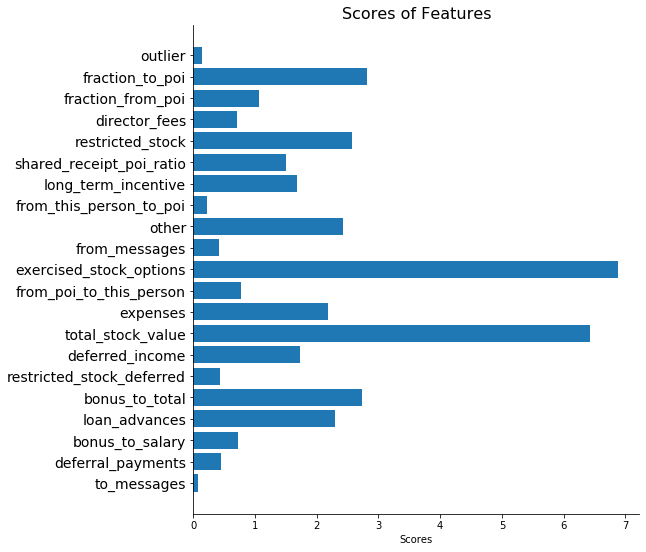

In [27]:
### Selecing the most important features for the given data

# Converting the boolean type of poi column to float values for classification
features_list = ['to_messages', 'deferral_payments', 'bonus_to_salary',
                 'loan_advances', 'bonus_to_total', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses',
                 'from_poi_to_this_person', 'exercised_stock_options', 'from_messages',
                 'other', 'from_this_person_to_poi', 'long_term_incentive',
                 'shared_receipt_poi_ratio', 'restricted_stock', 'director_fees',
                 'fraction_from_poi', 'fraction_to_poi','outlier']

labels = df_train["poi"].tolist()
features = df_train[features_list].values.tolist()

# Performing feature selection
selector = SelectKBest(f_classif, k=19)
selector.fit(features, labels)

scores = -np.log10(selector.pvalues_)

# Plotting the features wrt scores
figure, axes = plt.subplots(figsize=(8,9))
axes.barh(features_list, width=scores)
axes.set_yticklabels(features_list, fontsize=14)
axes.set_xlabel("Scores")
axes.set_title("Scores of Features", fontsize=16)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
plt.show()
df_score_eval = pd.DataFrame({'feature':features_list,'score':scores})

In [28]:
### Updated Features
# Selecting all the features with score > 2

updated_features_list = np.array(df_score_eval[df_score_eval.score>2]['feature'])
updated_features_list = np.append(updated_features_list,['outlier'])
labels = df_train["poi"].tolist()
features = df_train[updated_features_list].values.tolist()
#預測資料集
test_X = df_test[updated_features_list].values.tolist()
print(len(labels))
print(len(features))
print(len(test_X))
print(updated_features_list)

113
113
33
['loan_advances' 'bonus_to_total' 'total_stock_value' 'expenses'
 'exercised_stock_options' 'other' 'restricted_stock' 'fraction_to_poi'
 'outlier']


<a id='sec4'></a>
### 4. 套用模型

Different algorithms were attempted using the above mentioned feature list.
I tried **Decision Tree Classifier**, **Random Forest Classifier**, **Ada Boost Classifier**, **Gaussian Naive Bayes**, **K-Nearest Neighbors**

In [29]:
# Splitting up the data
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=67)

In [30]:
### Trying differnet algorithms
algorithms = []
accuracy = []
precision = []
recall = []
f1score = []

models = [("Decision Tree Classifier", DecisionTreeClassifier(random_state=42)),
          ("Gaussian Naive Bayes", GaussianNB()),
          ("Random Forest Classifier", RandomForestClassifier(random_state=42, n_estimators=100)),
          ("K Nearest Neighbors", KNeighborsClassifier()),
          ("Ada Boost Classifier", AdaBoostClassifier(random_state=42)),
          ("Logistic Regression", LogisticRegression()),
          ("GradientBoosting Classifier", GradientBoostingClassifier())]

for name, model in models:
    clf = model
    clf.fit(features_train, labels_train)
    predicitons = clf.predict(features_test)
    algorithms.append(name)
    accuracy.append(accuracy_score(labels_test, predicitons))
    precision.append(precision_score(labels_test, predicitons))
    recall.append(recall_score(labels_test, predicitons))
    f1score.append(f1_score(labels_test, predicitons))

evaluation_matrix = {"Algorithm": algorithms, "Accuracy": accuracy,
              "Precision": precision, "Recall": recall,
              "F1-Score": f1score}
evaluation = pd.DataFrame(evaluation_matrix)
evaluation

,Algorithm,Accuracy,Precision,Recall,F1-Score
0,Decision Tree Classifier,0.794118,0.600000,0.375,0.461538
1,Gaussian Naive Bayes,0.735294,0.428571,0.375,0.400000
2,Random Forest Classifier,0.823529,0.750000,0.375,0.500000
3,K Nearest Neighbors,0.764706,0.000000,0.000,0.000000
4,Ada Boost Classifier,0.794118,0.666667,0.250,0.363636
5,Logistic Regression,0.705882,0.000000,0.000,0.000000
6,GradientBoosting Classifier,0.735294,0.333333,0.125,0.181818


In [31]:
t0 = time()

clf = DecisionTreeClassifier(random_state=42)

clf.fit(features_train, labels_train)
predicitons = clf.predict(features_test)

accuracy.append((accuracy_score(labels_test, predicitons)))
precision.append((precision_score(labels_test, predicitons)))
recall.append((recall_score(labels_test, predicitons)))
f1score.append((f1_score(labels_test, predicitons)))

print("Accuracy:", round(accuracy_score(labels_test, predicitons), 3))
print("Precision:", round(precision_score(labels_test, predicitons), 3))
print("Recall:", round(recall_score(labels_test, predicitons), 3))
print("F1-Score:", round(f1_score(labels_test, predicitons), 3))
print("Done in", str(round(time()-t0, 3)) + "s")

Accuracy: 0.794
Precision: 0.6
Recall: 0.375
F1-Score: 0.462
Done in 0.0s


<a id='sec4.1'></a>
#### 4.1. 超參數調整

Parameter tuning for an algorithm means selecting the good and robust parameter or set of parameters for an algorithm to optimize its performance. Default parameters may not be customized very well for the particular dataset features and might result in poor performance. Scikit learn provides two methods for algorithm parameter tuning/Hyperparameter optimization- GridSearchCV and RandomizedSearchCV.

I used **GridSearchCV** to do exhaustive search over different parameters and find the best parameters.

1. I used the **'f1'** as my *"scoring"* parameter to guide the parameter search process to minimize False positives and False negatives.
2. In the **"cv"** parameter, I passed a *cross validation* object **StratifiedShuffleSplit** to validate my search results that best adapt to my dataset characteristics.
3. I am choosing Decision Tree Classifier as my final algorithm, lets tune it below

In [32]:
### Tuning the Hyper-Parameters
clf_parameters = { 'criterion': ['gini', 'entropy'],
                   'max_depth': [None, 1, 2, 4, 5, 10, 15, 20],
                   'min_samples_split': [2, 4, 6, 8, 10, 20, 30, 40],
                   'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 10, 20, 30] }

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=67)
clf = GridSearchCV(DecisionTreeClassifier(), param_grid = clf_parameters, cv = cv, scoring = 'f1')
clf.fit(features,labels)

best_clf_parameters = clf.best_estimator_
best_clf_parameters

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

*max_depth* determines when the splitting of decision tree node stops. *min_samples_split* monitors the amount of observations in an internal node; if a certain threshold is not reached (e.g min 5 people) no further splitting can be done. Very deep trees fit to quirks in data and perform well on training data, but will perform worse on test (unseen) data. We want our model to generalize better.

<a id='sec4.2'></a>
#### 4.2. 測試及驗證

**Validation** is the strategy to evaluate the performance of the model on unseen data. A classic mistake is to evaluate the performance of an algorithm on the same dataset it was trained on. It will make our algorithm perform better than it actually does. However, we will have no idea how our algorithm performs on unseen data.

It is essential practice in data mining procedures to keep a subset of data as holdout data- test data. We train our model on training data and examine the *generalization performance* of the model on the test data. We hide the label for target variable of the test data from the model and let the model predict the values for target variable. Then we compare the values predicted by the model with the hidden true values. We can also use a more sophisticated holdout training and testing procedure called cross-validation.

In our case, I used a variation of *k-fold cross-validation* called **StratifiedShuffleSplit**. StratifiedShuffleSplit will make randomly chosen training and test sets multiple times and average the results over all the tests. Data is first shuffled and then split into a pair of training and test sets. Stratification ensures training and test splits have class distribution (POI:Non-POI) that represents the overall data. Stratification is well suited in our case because of class imbalance (18 POI vs 128 Non-POI).

There are a number of evaluation metrics for classification challenges. In **balanced classes**, where all the labels are equally represented, we look at the classification **accuracy** of the model.

$$ Accuracy = \frac{Number\ of\ labels\ predicted\ correctly}{Total\ number\ of\ predicitions} = \frac{True\ Positives\ +\ True\ Negatives}{Total\ Predictions} $$

However, accuracy is not ideal for **skewed classes**. In our case, number of POI are small compared to non-POI (18 vs 128). We can have high accuracy by classifying many non-POI correctly and still not have a POI classiifed correctly. For imbalanced classes like we have, **Precision** and **Recall** are common measures of model performance.

$$ Precision = \frac{True\ Positive}{True\ Positive\ +\ False\ Positive} $$

$$ Recall = \frac{True\ Positive}{True\ Positive\ +\ False\ Positive} $$

A **good precision** means that whenever a POI gets flagged in my test set, I know with a lot of confidence that it's very likely to be a real POI and not a false alarm. A low precision indicates a large number of False Positives, where non-POI gets flagged as POI.

A **good recall** means nearly I am able to identify a POI everytime it shows up in test cases. A low recall indicates many False Negatives, where POIs don't get flagged correctly

F1 score conveys a balance between precision and recall. It is the harmonic mean of precision and recall.

$$ F_{1}\ Score = \frac{2 \cdot precision\cdot recall}{precision+ recall} $$

A **good F1-score** means both my false positives and false negatives are low, I can identify my POI's reliably and accurately. If my classifier flags a POI then the person is almost certainly a POI, and if the classifier does not flag someone, then they are almost certainly not a POI.

In [33]:
# 儲存預測結果(決策樹)
output_path = 'output/'
predicitons1 = best_clf_parameters.predict_proba(test_X)[:, 1]
submit = pd.DataFrame({'name': ids, 'poi': predicitons1})
outlier_set = ['TOTAL','THE TRAVEL AGENCY IN THE PARK']
f_app_result = os.path.join(output_path, 'Day_051_To_053_V1_dt.csv')
submit.to_csv(f_app_result,index=False)

#### Fit the model 堆疊泛化

In [34]:
from mlxtend.classifier import StackingClassifier
# 使用三種模型 : 邏輯斯迴歸 / 梯度提升機 / 隨機森林
lr =  LogisticRegression()
gdbt =  GradientBoostingClassifier()
rf =  RandomForestClassifier()
# 進行訓練
lr.fit(features,labels)
gdbt.fit(features,labels)
rf.fit(features,labels)

# stacking
meta_estimator = GradientBoostingClassifier(tol=100, subsample=0.70, n_estimators=50, 
                                           max_features='sqrt', max_depth=4, learning_rate=0.3)

stacking = StackingClassifier(classifiers = [lr, gdbt, rf], meta_classifier=meta_estimator,\
                              use_probas=True, average_probas=False)

stacking.fit(features,labels)
# 預測測試集
predicitons = stacking.predict(features_test)

# 分類要驗證正確率(accucry)
print("Accuracy:", round(accuracy_score(labels_test, predicitons), 3))
print("Precision:", round(precision_score(labels_test, predicitons), 3))
print("Recall:", round(recall_score(labels_test, predicitons), 3))
print("F1-Score:", round(f1_score(labels_test, predicitons), 3))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


In [35]:
# 儲存預測結果(堆疊泛化 )
output_path = 'output/'
predicitons1 = stacking.predict_proba(test_X)[:, 1]
submit = pd.DataFrame({'name': ids, 'poi': predicitons1})
f_app_result = os.path.join(output_path, 'Day_051_To_053_V1_stacking.csv')
submit.to_csv(f_app_result,index=False)